In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import (
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    Conv1D,
    Flatten,
    concatenate,
    GlobalAveragePooling1D,
    MaxPooling1D,
)
from keras.optimizers import SGD, Adam

# import mean_absolute_percentage_error
from keras.losses import mean_absolute_percentage_error

from IPython import display

from src.models import (
    plot_metrics,
    plot_test_performance,
    evaluate_test_performance,
    reg_cnn_model,
)

2023-06-15 10:46:05.207303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset

Load full dataset

In [2]:
input_file = "normalized_data.feather"
df = pd.read_feather(input_file)
total_rows = len(df)

print(f"Length of the dataset in {input_file}: {total_rows}")

Length of the dataset in normalized_data.feather: 51840


In [3]:
# Transform Signal column in a good type and shape
df["Signal"] = df["Signal"].apply(lambda x: [float(value) for value in x.split(" ")])
df.head()

,Drug1,Drug2,Conc1,Conc2,ScanRate,Capacitance,Signal,Sensitivity1,Sensitivity2,Peak_pos1,Peak_pos2,Peak_width1,Peak_width2,k_m1,k_m2,v_max1,v_max2
0,0,1,0.028169,0.028169,0.01,1.0,"[0.006850648514866037, 33.39623902311649, 66.7...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
1,0,1,0.028169,0.028169,0.10,1.0,"[0.006850648514866037, 3.3461764536005996, 6.6...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
2,0,1,0.028169,0.028169,1.00,1.0,"[0.006850648514866037, 0.34117019664901005, 0....",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
3,0,1,0.028169,0.070423,0.01,1.0,"[0.006858229126972536, 33.396248401363984, 66....",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
4,0,1,0.028169,0.070423,0.10,1.0,"[0.006858229126972536, 3.3461858318480897, 6.6...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499


# Correlation Analysis (Spearman)

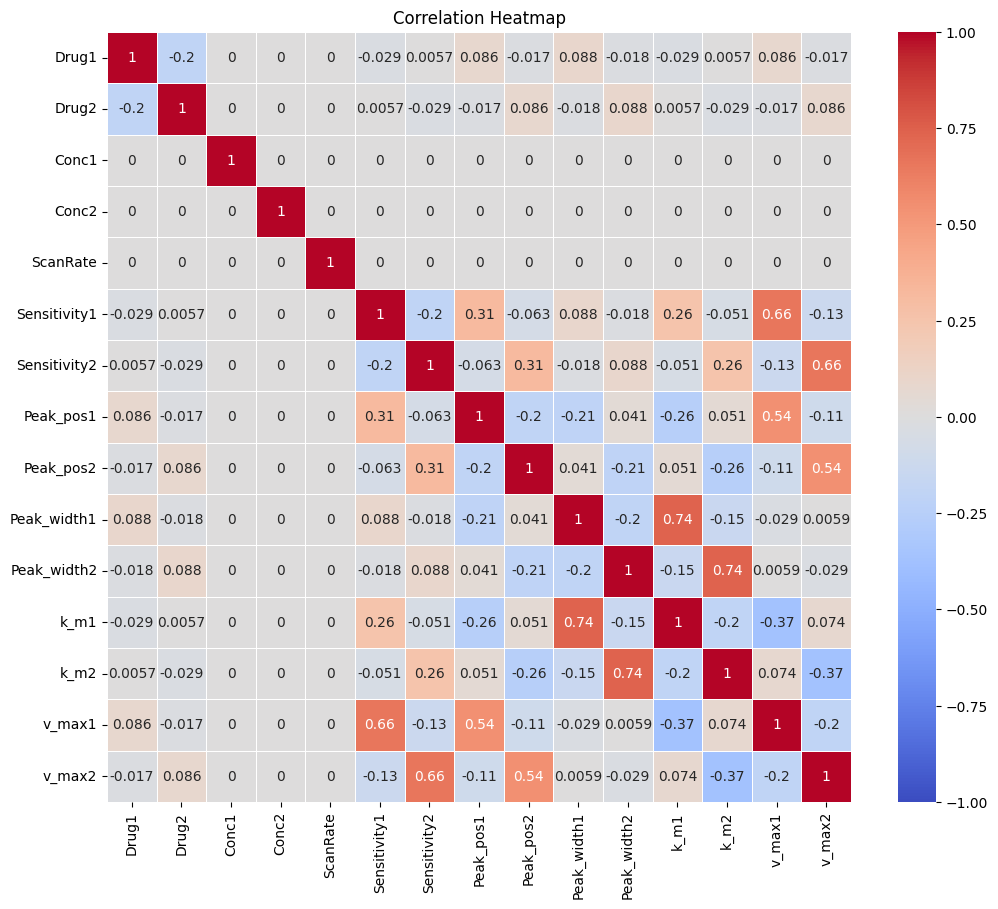

In [4]:
df_sample = df
# Remove the "Signal" column
data_no_signal = df_sample.drop(
    ["Signal", "Capacitance"], axis=1
)  # Remove useless column for correlation matrix

# Compute the correlation matrix
corr_matrix = data_no_signal.corr(method="spearman")

# Generate the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Drop automatically features with coeff > 0.6

Columns to drop: {'v_max1', 'v_max2', 'k_m2', 'k_m1'}


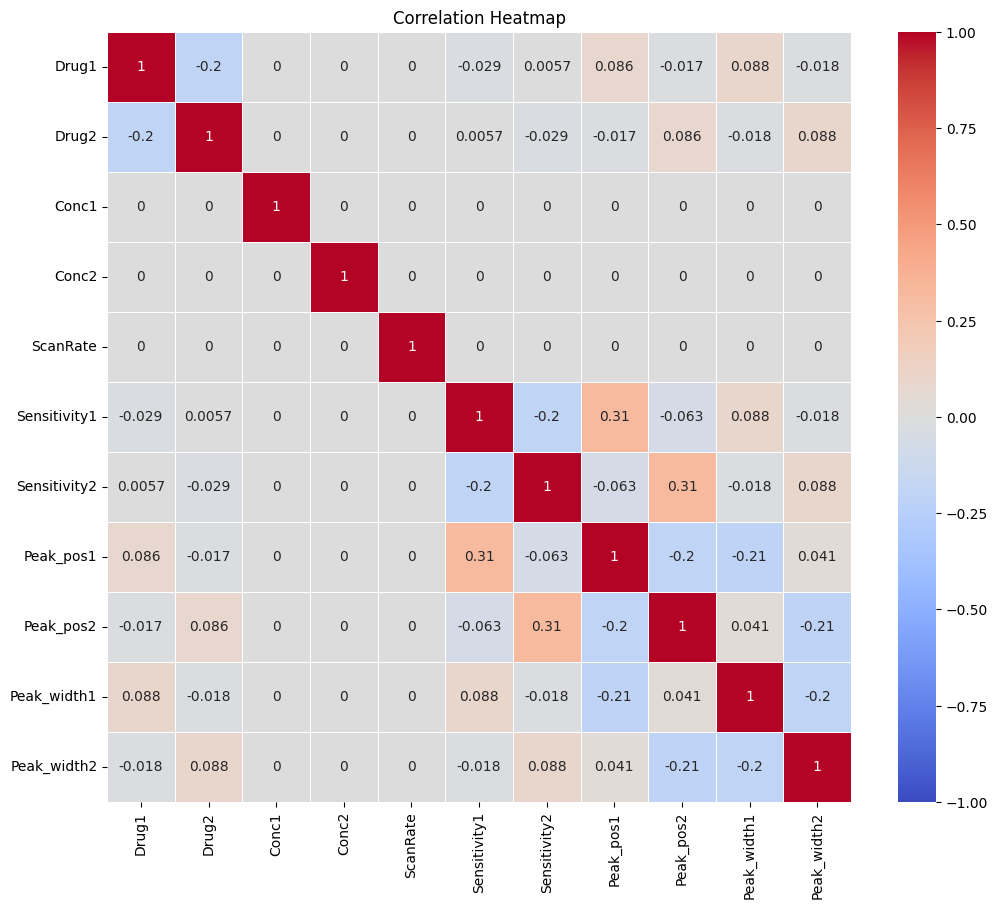

In [5]:
# drop the columns with correlation > 0.6

# Set the threshold
threshold = 0.6

# copy df_sample features names
df_features = data_no_signal.copy()
corr_matrix = df_features.corr(method="spearman")

# Iterate over the columns in reverse order
for col in reversed(corr_matrix.columns):
    # Find the indices of the columns with correlations greater than the threshold
    correlated_indices = np.where(abs(corr_matrix[col]) > threshold)[0]

    # If there are correlated columns other than the current column itself
    if len(correlated_indices) > 1:
        # Get the column names to drop
        columns_to_drop = corr_matrix.columns[correlated_indices][1]

        # Drop the correlated columns
        df_features.drop(columns=columns_to_drop, inplace=True)

        # Recalculate the correlation matrix
        corr_matrix = df_features.corr(method="spearman")

# print the droped columns
print(f"Columns to drop: {set(data_no_signal.columns) - set(df_features.columns)}")
features_to_drop = set(data_no_signal.columns) - set(df_features.columns)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Transform features in numpy array

In [6]:
processed_features = []
# build a list of all features in df_sample without the features to drop
features = [feature for feature in df_sample.columns if feature not in features_to_drop]
print(f"Features to use: {features}")
print(f"Features dropped: {features_to_drop}")

for feature in features:
    # if feature is different from "Conc1" and "Conc2" and "Signal"
    if feature != "Conc1" and feature != "Conc2" and feature != "Signal":
        process_feature = np.array(df_sample[feature])
        processed_features.append(process_feature)
    if feature == "Signal":
        Signal = np.array(df_sample["Signal"]).tolist()
        Signal_normalized = np.array(
            [signal / np.max(np.abs(signal)) for signal in Signal]
        )

X_other = np.column_stack(
    processed_features
)  # Equivalent to X_other = np.column_stack((Drug1, Drug2, Scan_Rate, Capacitance, Sensitivity1, Sensitivity2, Peak_pos1, Peak_pos2, Peak_width1, Peak_width2, v_max1, v_max2))

# Create target variables (Conc1 and Conc2)
Conc1 = np.array(df_sample["Conc1"])
Conc2 = np.array(df_sample["Conc2"])
Y = np.column_stack((Conc1, Conc2))

Features to use: ['Drug1', 'Drug2', 'Conc1', 'Conc2', 'ScanRate', 'Capacitance', 'Signal', 'Sensitivity1', 'Sensitivity2', 'Peak_pos1', 'Peak_pos2', 'Peak_width1', 'Peak_width2']
Features dropped: {'v_max1', 'v_max2', 'k_m2', 'k_m1'}


In [7]:
# Split data into training and test sets
(
    X_train_other,
    X_test_other,
    Signal_train,
    Signal_test,
    y_train,
    y_test,
) = train_test_split(
    X_other, Signal_normalized, Y, test_size=0.1, random_state=42, shuffle=True
)

# Create and train the model

In [8]:
# Plot the signal and the predicted signal
def plot_signal(signal, predicted_signal):
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label="signal")
    plt.plot(predicted_signal, label="predicted signal")
    plt.legend()
    plt.show()

In [10]:
def simple_model_Adam_best(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(96, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="relu")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error']) # To keep
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def simple_model_Adam_trial_1(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(192, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(96, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(12, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dense(3, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="relu")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def improved_model_Adam_trial_2(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization
    x = Dense(256, kernel_initializer="he_normal")(combined)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64, kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2)(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def simple_model_SGD(n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(96, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="linear")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = SGD(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model

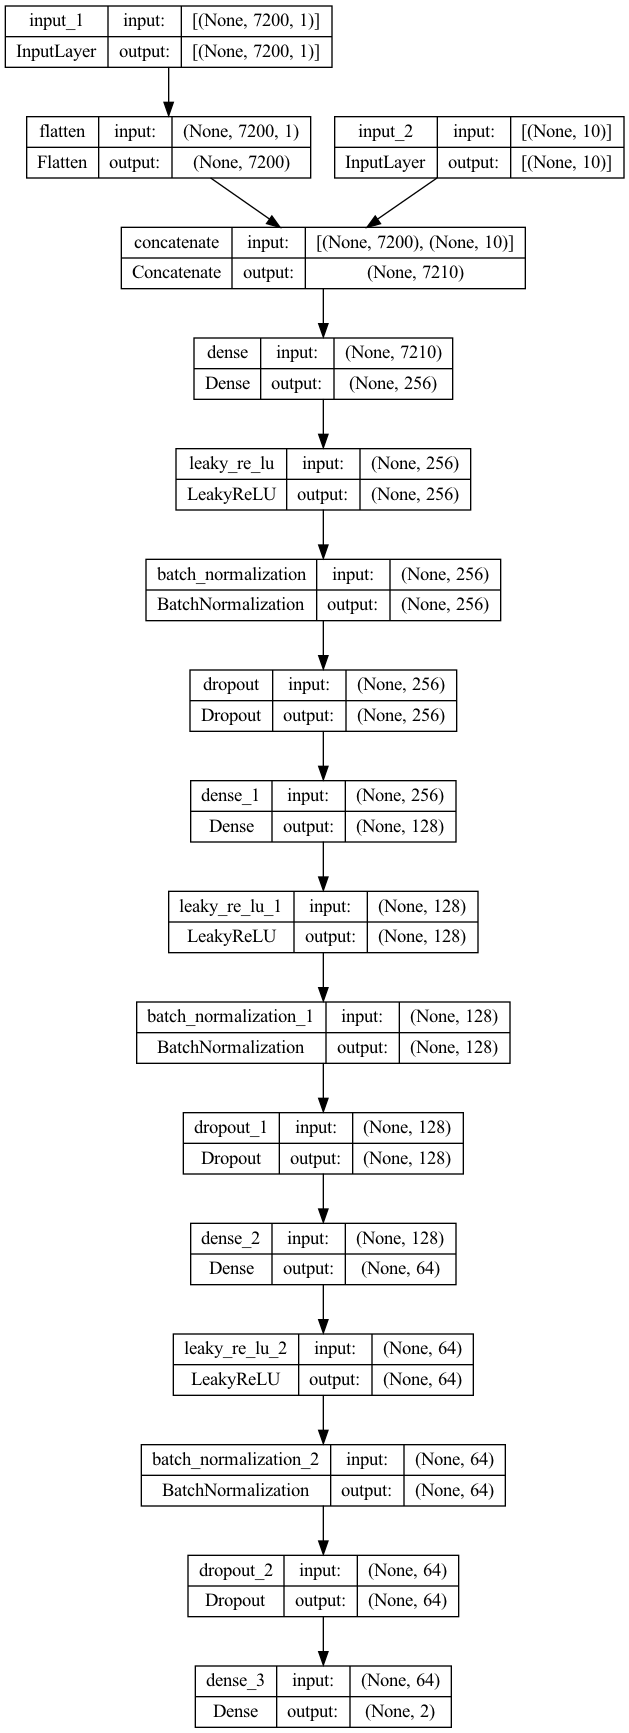

In [11]:
model = improved_model_Adam_trial_2(
    X_other.shape[1], initial_lr=0.001, decay_steps=9000, decay_rate=0.95
)

# draw the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/100
292/292 [==============================] - 9s 25ms/step - loss: 0.7800 - mean_absolute_percentage_error: 289.0664 - val_loss: 0.0940 - val_mean_absolute_percentage_error: 140.0822
Epoch 2/100
292/292 [==============================] - 4s 14ms/step - loss: 0.2788 - mean_absolute_percentage_error: 202.0389 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 150.4109
Epoch 3/100
292/292 [==============================] - 4s 14ms/step - loss: 0.1631 - mean_absolute_percentage_error: 167.9664 - val_loss: 0.0801 - val_mean_absolute_percentage_error: 148.3016
Epoch 4/100
292/292 [==============================] - 4s 15ms/step - loss: 0.1149 - mean_absolute_percentage_error: 154.9762 - val_loss: 0.0802 - val_mean_absolute_percentage_error: 148.2066
Epoch 5/100
292/292 [==============================] - 5s 15ms/step - loss: 0.0955 - mean_absolute_percentage_error: 151.2989 - val_loss: 0.0800 - val_mean_absolute_percentage_error: 145.7413
Epoch 6/100
292/292 [===================

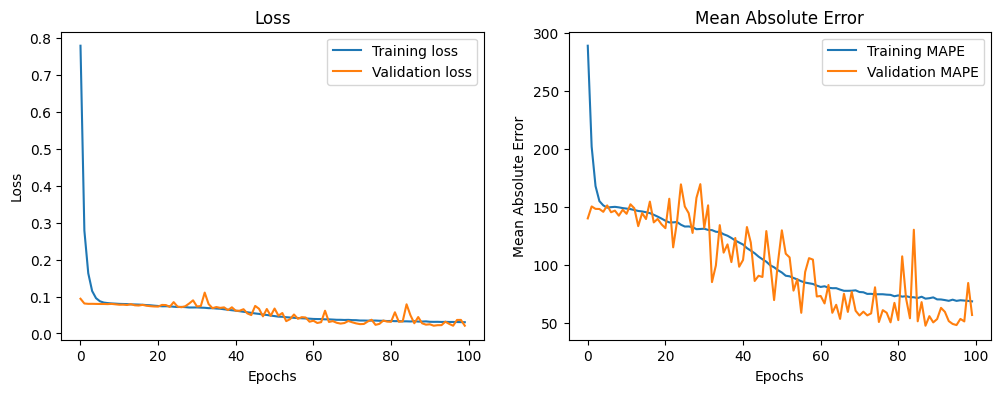

162/162 [==============================] - 1s 3ms/step - loss: 0.0218 - mean_absolute_percentage_error: 59.3380
Test Loss: 0.02179708518087864, Test Mean Absolute Error: 59.337955474853516
162/162 [==============================] - 1s 3ms/step


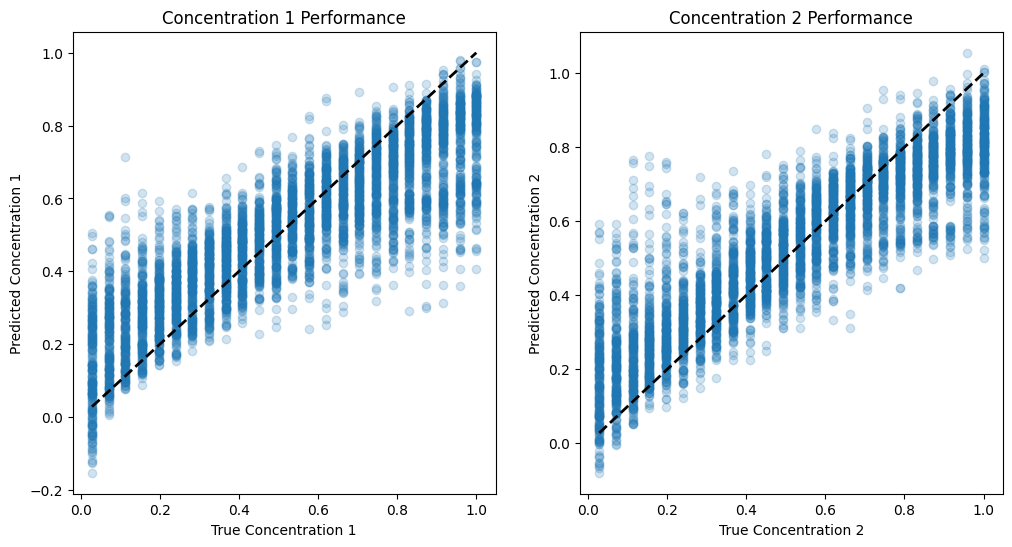

In [25]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 3ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 58.45671195285043%
Standard Deviation of Percentage Error on concentration 1: 139.7913687379549%
Mean Percentage Error on concentration 2: 60.21919325239004%
Standard Deviation of Percentage Error on concentration 2: 160.14884451344872%


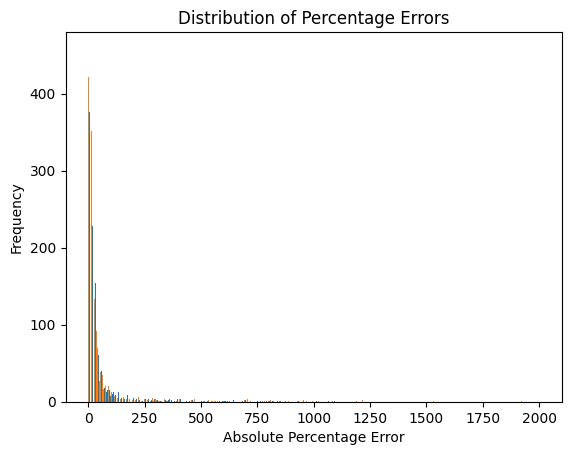

In [26]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins="auto")
    # zoom on the first 30% of the data
    # plt.xlim(0, 500)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.show()

evaluate_model(model, Signal_test, X_test_other, y_test)

# BEST MODEL

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7200, 1)]    0           []                               
                                                                                                  
 flatten (Flatten)              (None, 7200)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7210)         0           ['flatten[0][0]',                
                                                                  'input_2[0][0]']            

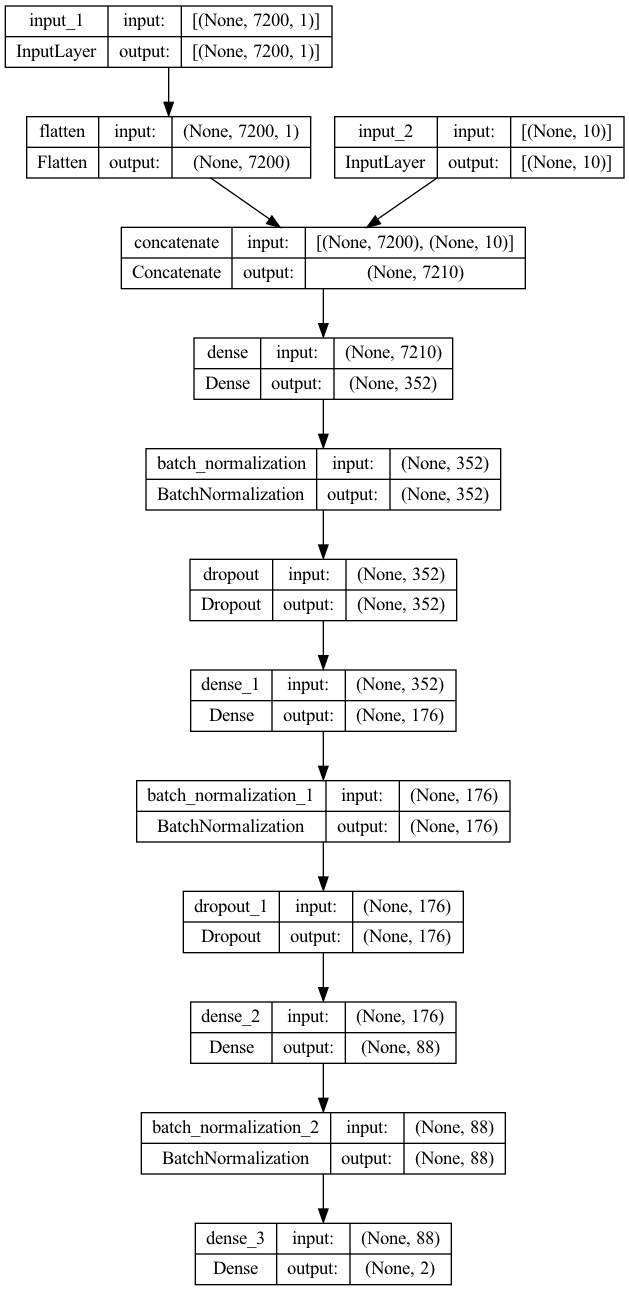

In [8]:
def create_model(
    input_shape_signal,
    input_shape_other,
    units,
    dropout_rate,
    num_layers,
    initial_lr=0.00020812318085000362,
    decay_steps=20000,
    decay_rate=0.95,
):
    # Define the inputs
    input_signal = Input(shape=input_shape_signal)
    flat_signal = Flatten()(input_signal)
    input_other = Input(shape=input_shape_other)

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers
    x = Dense(units, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    for i in range(num_layers - 1):
        x = Dense(
            units // (2 ** (i + 1)), activation="relu", kernel_initializer="he_normal"
        )(x)
        x = BatchNormalization()(x)
        if i < num_layers - 2:  # Apply dropout to all layers except the last one
            x = Dropout(dropout_rate)(x)

    # Output
    output = Dense(2, activation="relu")(x)

    # Learning rate and optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=initial_lr)

    # Model and compilation
    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


# Define your hyperparameters
input_shape_signal = (7200, 1)
input_shape_other = (X_train_other.shape[1],)
units = 352
dropout_rate = 0.0
initial_lr = 0.00020812318085000362
num_layers = 3

# Create the model
model = create_model(
    input_shape_signal,
    input_shape_other,
    units,
    dropout_rate,
    num_layers,
    initial_lr=initial_lr,
)

# Print a summary of the model
model.summary()
# draw the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Batchsize 32

In [9]:
from keras.callbacks import ModelCheckpoint

# Initialize the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="best_model.h5",  # Path where to save the model
    monitor="val_mean_absolute_percentage_error",  # The performance measure to decide when to save
    verbose=1,  # Whether to print a message when saving
    save_best_only=True,  # Only save the best model
    mode="min",  # Aim to minimize validation loss
)

Epoch 1/250
1167/1167 [==============================] - ETA: 0s - loss: 0.1440 - mean_absolute_percentage_error: 138.1352
Epoch 1: val_mean_absolute_percentage_error improved from inf to 159.27579, saving model to best_model.h5
1167/1167 [==============================] - 21s 15ms/step - loss: 0.1440 - mean_absolute_percentage_error: 138.1352 - val_loss: 0.1158 - val_mean_absolute_percentage_error: 159.2758
Epoch 2/250
1165/1167 [============================>.] - ETA: 0s - loss: 0.0815 - mean_absolute_percentage_error: 137.9417
Epoch 2: val_mean_absolute_percentage_error improved from 159.27579 to 132.65182, saving model to best_model.h5
1167/1167 [==============================] - 18s 15ms/step - loss: 0.0815 - mean_absolute_percentage_error: 137.9572 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 132.6518
Epoch 3/250
1165/1167 [============================>.] - ETA: 0s - loss: 0.0738 - mean_absolute_percentage_error: 134.6416
Epoch 3: val_mean_absolute_percentage_error did

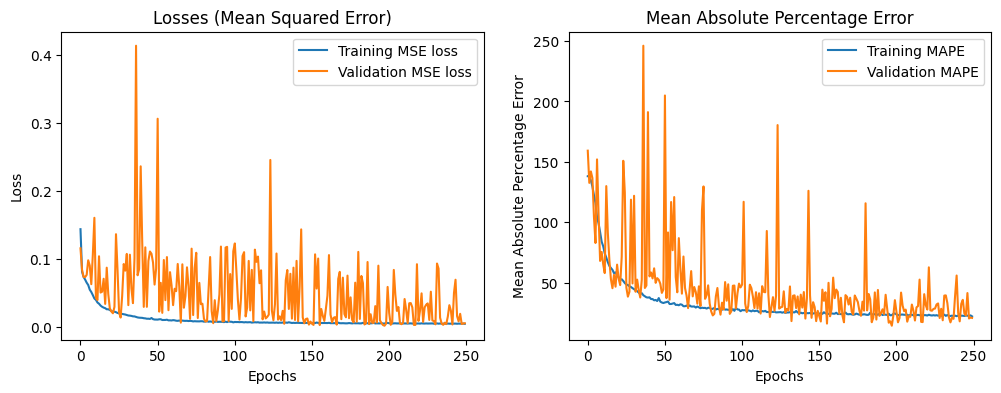

162/162 [==============================] - 1s 3ms/step - loss: 0.0054 - mean_absolute_percentage_error: 20.7232
Test Loss: 0.005386358592659235, Test Mean Absolute Error: 20.723182678222656
162/162 [==============================] - 1s 3ms/step


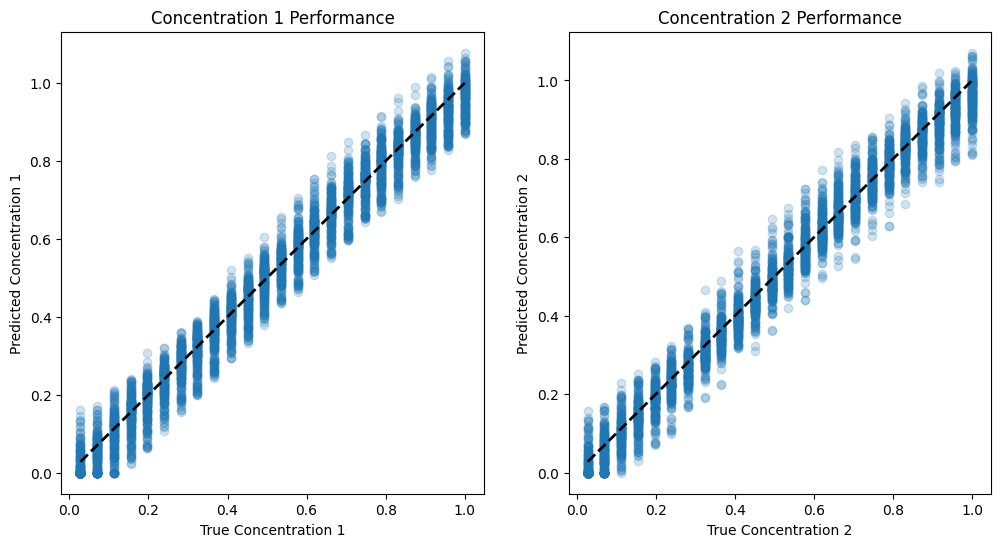

162/162 [==============================] - 1s 3ms/step - loss: 0.0021 - mean_absolute_percentage_error: 14.9188
Test Loss: 0.002084596548229456, Test Mean Absolute Error: 14.918771743774414


In [10]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[model_checkpoint],  # Add the callback here
)

# After training, load the best model
best_model = tf.keras.models.load_model("best_model.h5")

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(best_model, Signal_test, X_test_other, y_test)
# Evaluate the model on the test set
test_loss, test_mae = best_model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

162/162 [==============================] - 1s 5ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 15.252903249993091%
Standard Deviation of Percentage Error on concentration 1: 28.26453916625815%
Mean Percentage Error on concentration 2: 14.584643330612296%
Standard Deviation of Percentage Error on concentration 2: 28.45809118718091%


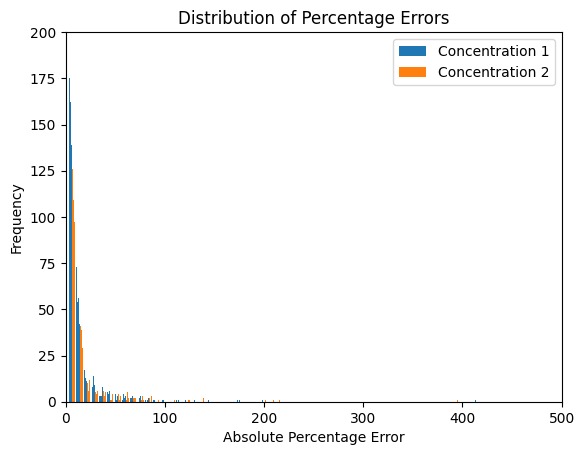

In [10]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins=1000)
    # zoom on the first 30% of the data
    plt.xlim(0, 500)
    plt.ylim(0, 200)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    # add legend for concentration 1 and concentration 2
    plt.legend(["Concentration 1", "Concentration 2"])
    plt.show()


# After training, load the best model
best_model = tf.keras.models.load_model("best_model.h5")
# Use the function on your model and test set
# replace "your_model" with the variable of your model
evaluate_model(best_model, Signal_test, X_test_other, y_test)

In [11]:
del model
del history